- Ler os dados disponíveis no Google Drive

In [1]:
%matplotlib inline

# Importar as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import os
import matplotlib.image as mpimg
import sys
import itertools
import tensorflow as tf
# import cv2

from scipy import signal as sg
from scipy import ndimage as sc
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.layers import Input
from keras.models import model_from_json
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
from keras.utils import np_utils
from keras.optimizers import SGD, Adadelta
from keras import regularizers

# Exibir 10 linhas do conjunto de dados
pd.set_option("max_r",10)
pd.get_option("display.max_rows")

# Estilo do Gráfico
import matplotlib
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive/My Drive/01. Unicamp - Mestrado FT/Disciplinas/201802 - MO444 - Aprendizado de Máquina e Reconhecimento de Padrões/Tarefas/Projeto/Programas/Graficos')

In [3]:
def accuracy_normalized(y_true,y_pred):
    mc = confusion_matrix(y_true,y_pred)
    mc_margin = np.sum(mc,axis = 1)

    n = len(mc)

    tp = []
    for i in range(n):
        tp.append(mc[i][i]/mc_margin[i])

    accuracy_normalized = np.sum(tp)/n 

    return accuracy_normalized

def acuracia(y_true,y_pred):
    mc = confusion_matrix(y_true,y_pred)
    mc_tot = np.sum(mc)
    n = len(mc)

    tp = []
    for i in range(n):
        tp.append(mc[i][i])

    accuracy = np.sum(tp)/mc_tot 

    return accuracy

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusão',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Observado', fontsize=14)
    plt.xlabel('Predito', fontsize=14)
    plt.tight_layout()

____

## Base de dados

Será utilizado o conjunto de dados `fer2013`.


In [4]:
# !pip install -U -q PyDrive

# from google.colab import auth
# auth.authenticate_user()

# from pydrive.drive import GoogleDrive
# from pydrive.auth import GoogleAuth
# from oauth2client.client import GoogleCredentials
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# # https://drive.google.com/file/d/1VjmDEp_VATI3_qk4t3s1lVvqIBNQBr96/view?usp=sharing
# fer2013 = drive.CreateFile({'id': '1VjmDEp_VATI3_qk4t3s1lVvqIBNQBr96'})
# fer2013.GetContentFile('fer2013.csv')
# dados = pd.DataFrame(pd.read_csv('fer2013.csv'))

print( os.getcwd() )
DIR = os.getcwd()
dados = pd.DataFrame(pd.read_csv('Dados/fer2013/fer2013.csv'))
dados

E:\Mestrado\Disciplinas\201802 - MO444 - Aprendizado de Máquina e Reconhecimento de Padrões\Projeto\Programas


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [5]:
d={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

count = pd.DataFrame(np.c_[dados.emotion.apply(lambda x:d[x]),dados.Usage,np.ones(len(dados))], columns=['emotion','Usage','number'])
count_train = pd.DataFrame(count[count['Usage'] == 'Training'].groupby(['Usage','emotion']).sum())
count_test = pd.DataFrame(count[count['Usage'] == 'PrivateTest'].groupby(['Usage','emotion']).sum())
count_val = pd.DataFrame(count[count['Usage'] == 'PublicTest'].groupby(['Usage','emotion']).sum())

In [6]:
count_train

number
Usage    emotion         
Training Angry     3995.0
         Disgust    436.0
         Fear      4097.0
         Happy     7215.0
         Neutral   4965.0
         Sad       4830.0
         Surprise  3171.0

In [10]:
count_val

number
Usage      emotion         
PublicTest Angry      467.0
           Disgust     56.0
           Fear       496.0
           Happy      895.0
           Neutral    607.0
           Sad        653.0
           Surprise   415.0

In [9]:
count_test

number
Usage       emotion         
PrivateTest Angry      491.0
            Disgust     55.0
            Fear       528.0
            Happy      879.0
            Neutral    626.0
            Sad        594.0
            Surprise   416.0

In [7]:
dados['pixels'] = dados['pixels'].apply(lambda x: np.fromstring(x,sep=' '))

## Conjunto de dados

- Teste

In [8]:
test = dados.loc[dados['Usage'] == 'PrivateTest']
# test = test.sample(300)
test.shape

(3589, 3)

In [11]:
test_x = np.vstack(test['pixels'].values)
test_x.shape

(3589, 2304)

In [12]:
# test_y = test['emotion']
test_y = pd.get_dummies(test['emotion'])
test_y.columns = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
test_y.shape

(3589, 7)

- Validação

In [13]:
validation = dados.loc[dados['Usage'] == 'PublicTest']
# validation = validation.sample(300)
validation.shape

(3589, 3)

In [14]:
validation_x = np.vstack(validation['pixels'].values)
validation_x.shape

(3589, 2304)

In [15]:
# validation_y = validation['emotion']
validation_y = pd.get_dummies(validation['emotion'])
validation_y.columns = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
validation_y.shape

(3589, 7)

- Treinamento

In [17]:
train = dados.loc[dados['Usage'] == 'Training']
# train = train.sample(500)
train.shape

(28709, 3)

In [18]:
train_x = np.vstack(train['pixels'].values)
train_x.shape

(28709, 2304)

In [19]:
# train_y = train['emotion']
train_y = pd.get_dummies(train['emotion'])
train_y.columns = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
train_y.shape

(28709, 7)

# Dados para modelagem

In [20]:
train_x_conv = np.reshape(train_x,(-1, 1, 48, 48))
validation_x_conv = np.reshape(validation_x,(-1, 1, 48, 48))
test_x_conv = np.reshape(test_x,(-1, 1, 48, 48))

In [21]:
print('Treinamento')
print('Variáveis: ',train_x_conv.shape,', Resposta: ',train_y.shape)

print('\nValidação')
print('Variáveis: ',validation_x_conv.shape,', Resposta: ',validation_y.shape)

print('\nTeste')
print('Variáveis: ',test_x_conv.shape,', Resposta: ',test_y.shape)


Treinamento
Variáveis:  (28709, 1, 48, 48) , Resposta:  (28709, 7)

Validação
Variáveis:  (3589, 1, 48, 48) , Resposta:  (3589, 7)

Teste
Variáveis:  (3589, 1, 48, 48) , Resposta:  (3589, 7)


#### Exemplo

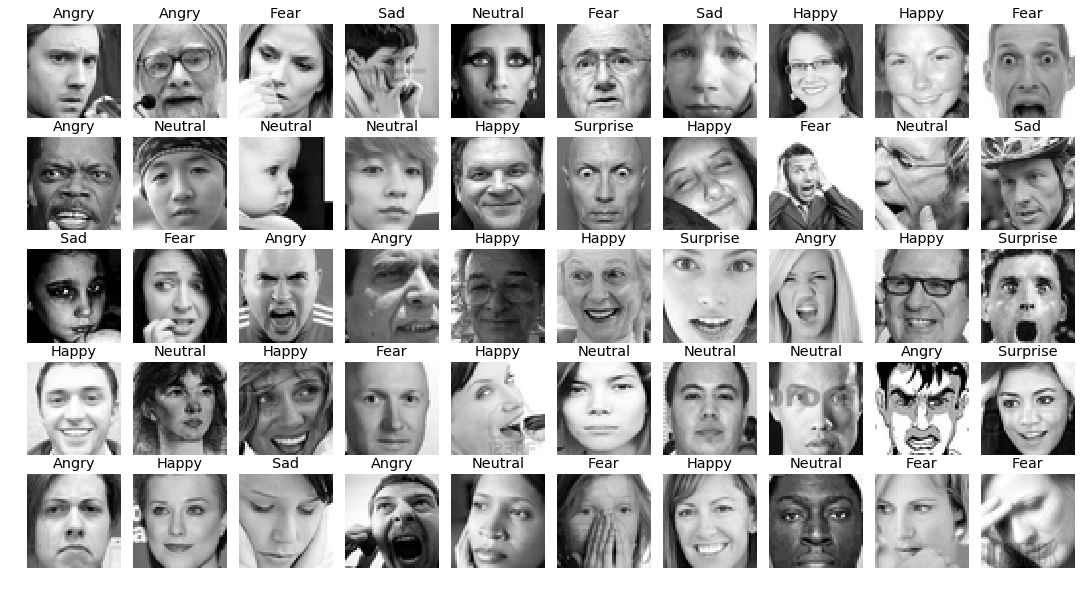

In [22]:
fig, axs = plt.subplots(5,10, figsize=(19, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.0001)
axs = axs.ravel()

for i in range(50):
    axs[i].imshow(train_x_conv.squeeze()[i], cmap='gray')
    axs[i].set_title(train_y.loc[i,train_y.loc[i]==1].index[0])
    axs[i].axis('off')

In [23]:
train_x_conv = train_x_conv.astype('float32') / 255
test_x_conv = test_x_conv.astype('float32') / 255
validation_x_conv  = validation_x_conv.astype('float32') / 255

In [24]:
print('Treinamento')
print('Variáveis: ',train_x_conv.shape,', Resposta: ',train_y.shape)

print('\nValidação')
print('Variáveis: ',validation_x_conv.shape,', Resposta: ',validation_y.shape)

print('\nTeste')
print('Variáveis: ',test_x_conv.shape,', Resposta: ',test_y.shape)


Treinamento
Variáveis:  (28709, 1, 48, 48) , Resposta:  (28709, 7)

Validação
Variáveis:  (3589, 1, 48, 48) , Resposta:  (3589, 7)

Teste
Variáveis:  (3589, 1, 48, 48) , Resposta:  (3589, 7)


In [25]:
num_classes = train_y.shape[1]
num_classes

input_shape = (1, 48, 48)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 44, 44)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 44, 44)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 22, 44)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 20, 64)        25408     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 20, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 20, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 10, 64)         0         
__________

28709/28709 [==============================] - 341s 12ms/step - loss: 0.8857 - acc: 0.6691 - val_loss: 1.3650 - val_acc: 0.5057

Epoch 00023: val_loss did not improve from 1.29183
Epoch 24/30
28709/28709 [==============================] - 343s 12ms/step - loss: 0.8343 - acc: 0.6905 - val_loss: 1.3735 - val_acc: 0.5191

Epoch 00024: val_loss did not improve from 1.29183
Epoch 25/30
28709/28709 [==============================] - 349s 12ms/step - loss: 0.8175 - acc: 0.6990 - val_loss: 1.3513 - val_acc: 0.5272

Epoch 00025: val_loss did not improve from 1.29183
Epoch 26/30
28709/28709 [==============================] - 349s 12ms/step - loss: 0.7730 - acc: 0.7146 - val_loss: 1.3743 - val_acc: 0.5194

Epoch 00026: val_loss did not improve from 1.29183
Epoch 27/30
28709/28709 [==============================] - 400s 14ms/step - loss: 0.7486 - acc: 0.7237 - val_loss: 1.4348 - val_acc: 0.5132

Epoch 00027: val_loss did not improve from 1.29183
Epoch 28/30
28709/28709 [===========================

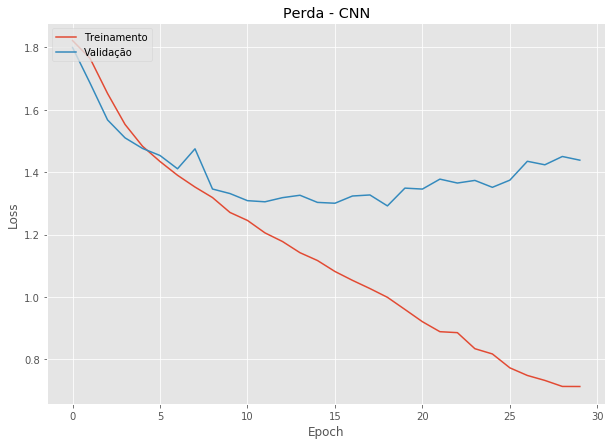

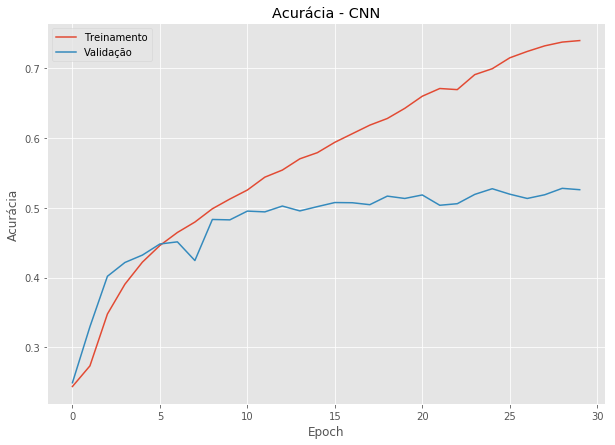

Conjunto de Treinamento
Acurácia Normalizada:  81.32
Acurácia:  83.42
Conjunto de Validação
Acurácia Normalizada:  48.38
Acurácia:  52.58


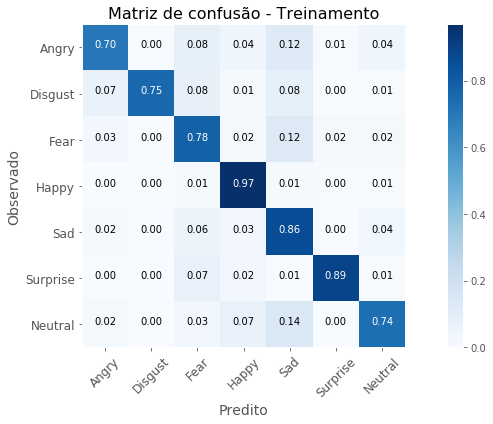

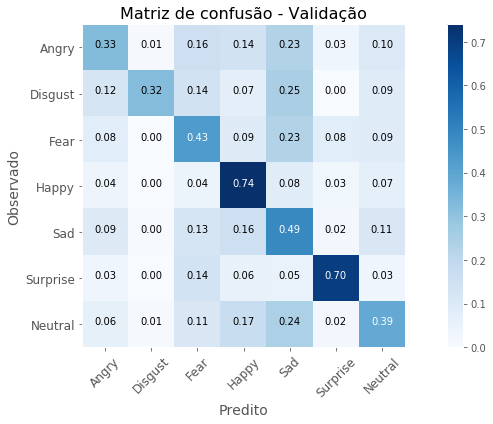

In [28]:
#inicia CNN simples
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=input_shape, data_format="channels_first"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))  
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax')) #Probabilidade de cada classe

model.summary()

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

checkpointer   = ModelCheckpoint(filepath=os.path.join('./TensorBoard/cnn1_emocoes_weights_simples.h5'), verbose=1, save_best_only=True)
csv_logger     = CSVLogger(os.path.join('./TensorBoard/cnn1_training_simples.log'))
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=8, verbose=1, mode='auto')
tensorboard = TensorBoard('./TensorBoard', histogram_freq=1,  write_graph=True, write_images=True)

model_history = model.fit(train_x_conv, train_y, epochs=30, batch_size=512, shuffle=True, validation_data=(validation_x_conv, validation_y), verbose=1, callbacks=[tensorboard, early_stopping, checkpointer, csv_logger])

print(model_history.history.keys())

fig = plt.figure(figsize = (10,7))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Perda - CNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
fig.savefig('Graficos/cnn1_hist_perda.png', figsize=(10, 7), dpi=200, bbox_inches='tight')

fig =plt.figure(figsize = (10,7))
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Acurácia - CNN')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()
fig.savefig('Graficos/cnn1_hist_acuracia.png', figsize=(10, 7), dpi=200, bbox_inches='tight')

# Probabilidades de cada classe
predito = model.predict_classes(train_x_conv)
predito_new = model.predict_classes(validation_x_conv)

obs = train['emotion']
obs_new = validation['emotion']

classes = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

fig, axes1 = plt.subplots(nrows=1, ncols=1,figsize=(12,6))
graf_confusion_new = plot_confusion_matrix(confusion_matrix(obs,predito), normalize = True, classes=classes,title="Matriz de confusão - Treinamento")
axes1.grid(b=False)
fig = axes1.get_figure()
fig.savefig("Graficos/cnn1_confusion_treinamento.png", figsize=(7, 7), dpi=200, bbox_inches='tight')     

print('Conjunto de Treinamento')
print('Acurácia Normalizada: ', np.round(accuracy_normalized(obs,predito)*100,2))
print('Acurácia: ', np.round(acuracia(obs,predito)*100,2))

fig, axes2 = plt.subplots(nrows=1, ncols=1,figsize=(12,6))
graf_confusion_new = plot_confusion_matrix(confusion_matrix(obs_new,predito_new), normalize = True, classes=classes,title="Matriz de confusão - Validação")
axes2.grid(b=False)
fig = axes2.get_figure()
fig.savefig("Graficos/cnn1_confusion_validacao.png", figsize=(7, 7), dpi=200, bbox_inches='tight')     

print('Conjunto de Validação')
print('Acurácia Normalizada: ', np.round(accuracy_normalized(obs_new,predito_new)*100,2))
print('Acurácia: ', np.round(acuracia(obs_new,predito_new)*100,2))

In [27]:
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 44, 44)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 44, 44)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 40, 64)        70464     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 40, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 18, 128)       73856     
_________________________________________________________________
activation_3 (Activation)    (None, 12, 18, 128)       0         
__________

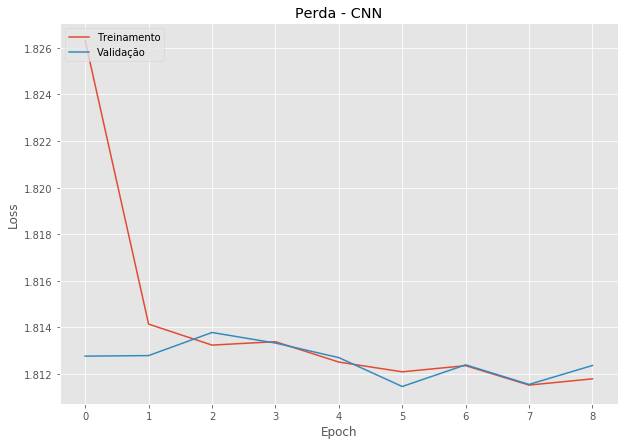

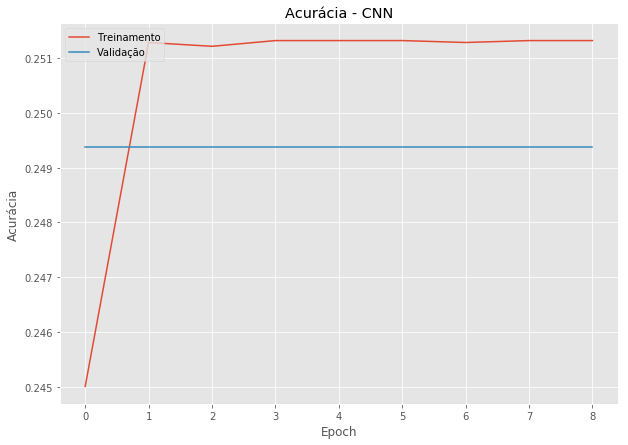

Conjunto de Treinamento
Acurácia Normalizada:  14.29
Acurácia:  25.13
Conjunto de Validação
Acurácia Normalizada:  14.29
Acurácia:  24.94


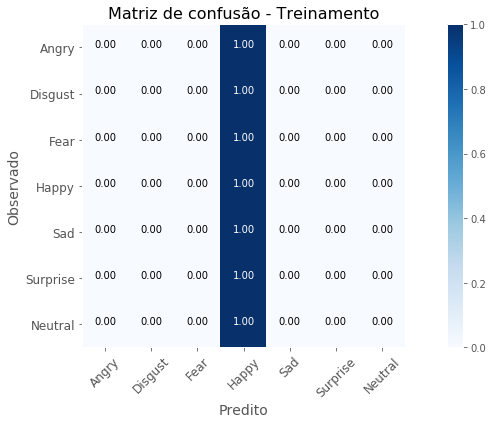

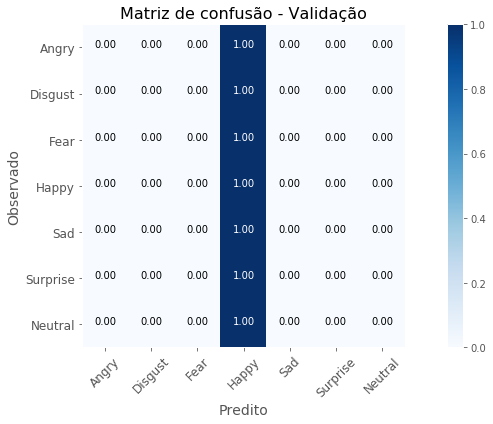

In [26]:
train_x_conv = train_x_conv.astype('float32') / 255
test_x_conv = test_x_conv.astype('float32') / 255
validation_x_conv  = validation_x_conv.astype('float32') / 255

num_classes = train_y.shape[1]
num_classes

input_shape = (1, 48, 48)

#inicia CNN 
model2 = Sequential()
model2.add(Conv2D(32, (5, 5), input_shape=input_shape, data_format="channels_first"))
model2.add(Activation('relu'))

model2.add(Conv2D(64, (5, 5)))  
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Dropout(0.1))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())

model2.add(Dense(2048))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Dense(1024))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Dense(num_classes))
model2.add(Activation('softmax')) #Probabilidade de cada classe

model2.summary()

model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

checkpointer   = ModelCheckpoint(filepath=os.path.join('./TensorBoard/cnn2_emocoes_weights_art_5147982.h5'), verbose=1, save_best_only=True)
csv_logger     = CSVLogger(os.path.join('./TensorBoard/cnn2_training_art_5147982.log'))
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=8, verbose=1, mode='auto')
tensorboard = TensorBoard('./TensorBoard', histogram_freq=1,  write_graph=True, write_images=True)

# https://cloud.google.com/tpu/docs/quickstart
# executar no prompt: tensorboard --logdir "E:/Mestrado/Disciplinas/201802 - MO444 - Aprendizado de Máquina e Reconhecimento de Padrões/Projeto/Programas/TensorBoard/"
# abrir no navegador http://<your-ip>:6006, no meu caso, http://desktop-4pqid90:6006/

model_history2 = model2.fit(train_x_conv, train_y, epochs=25, batch_size=512, shuffle=True, validation_data=(validation_x_conv, validation_y), verbose=1, callbacks=[tensorboard, early_stopping, checkpointer, csv_logger])

fig = plt.figure(figsize = (10,7))
plt.plot(model_history2.history['loss'])
plt.plot(model_history2.history['val_loss'])
plt.title('Perda - CNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
fig.savefig('Graficos/cnn2_hist_perda.png', figsize=(10, 7), dpi=200, bbox_inches='tight')

fig =plt.figure(figsize = (10,7))
plt.plot(model_history2.history['acc'])
plt.plot(model_history2.history['val_acc'])
plt.title('Acurácia - CNN')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()
fig.savefig('Graficos/cnn2_hist_acuracia.png', figsize=(10, 7), dpi=200, bbox_inches='tight')


# Probabilidades de cada classe
predito2 = model2.predict_classes(train_x_conv)
predito_new2 = model2.predict_classes(validation_x_conv)

obs2 = train['emotion']
obs_new2 = validation['emotion']

classes = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

fig, axes1 = plt.subplots(nrows=1, ncols=1,figsize=(12,6))
graf_confusion_new = plot_confusion_matrix(confusion_matrix(obs2,predito2), normalize = True, classes=classes,title="Matriz de confusão - Treinamento")
axes1.grid(b=False)
fig = axes1.get_figure()
fig.savefig("Graficos/cnn2_confusion_treinamento.png", figsize=(7, 7), dpi=200, bbox_inches='tight')     

print('Conjunto de Treinamento')
print('Acurácia Normalizada: ', np.round(accuracy_normalized(obs2,predito2)*100,2))
print('Acurácia: ', np.round(acuracia(obs2,predito2)*100,2))

fig, axes2 = plt.subplots(nrows=1, ncols=1,figsize=(12,6))
graf_confusion_new = plot_confusion_matrix(confusion_matrix(obs_new2,predito_new2), normalize = True, classes=classes,title="Matriz de confusão - Validação")
axes2.grid(b=False)
fig = axes2.get_figure()
fig.savefig("Graficos/cnn2_confusion_validacao.png", figsize=(7, 7), dpi=200, bbox_inches='tight')        


print('Conjunto de Validação')
print('Acurácia Normalizada: ', np.round(accuracy_normalized(obs_new2,predito_new2)*100,2))
print('Acurácia: ', np.round(acuracia(obs_new2,predito_new2)*100,2))